In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7" #! NOTE: CHANGE TO 0,1 FOR VAST AI
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-06-27 07:07:46 __main__ INFO     torch.__version__='2.7.1+cu126', torch.version.cuda='12.6'
2025-06-27 07:07:47 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-06-27 07:07:47 __main__ INFO     transformers.__version__='4.53.0'


In [3]:
from src.utils.training_utils import get_device_map

model_key = "meta-llama/Llama-3.3-70B-Instruct"

device_map = get_device_map(model_key, 30, n_gpus=8) #! NOTE: CHANGE n_gpus=2 FOR VAST AI
device_map

2025-06-27 07:07:51 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
2025-06-27 07:07:51 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/mechinterp, stdin=None, shell=False, universal_newlines=False)
x: 42
y: hello


{'model.embed_tokens': 7,
 'model.norm': 7,
 'model.rotary_emb': 7,
 'lm_head': 7,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 2,
 'model.layers.3': 3,
 'model.layers.4': 4,
 'model.layers.5': 5,
 'model.layers.6': 6,
 'model.layers.7': 7,
 'model.layers.8': 0,
 'model.layers.9': 1,
 'model.layers.10': 2,
 'model.layers.11': 3,
 'model.layers.12': 4,
 'model.layers.13': 5,
 'model.layers.14': 6,
 'model.layers.15': 7,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 2,
 'model.layers.19': 3,
 'model.layers.20': 4,
 'model.layers.21': 5,
 'model.layers.22': 6,
 'model.layers.23': 7,
 'model.layers.24': 0,
 'model.layers.25': 1,
 'model.layers.26': 2,
 'model.layers.27': 3,
 'model.layers.28': 4,
 'model.layers.29': 5,
 'model.layers.30': 0,
 'model.layers.31': 1,
 'model.layers.32': 2,
 'model.layers.33': 3,
 'model.layers.34': 4,
 'model.layers.35': 5,
 'model.layers.36': 6,
 'model.layers.37': 7,
 'model.layers.38': 0,
 'model.layers.39': 1,
 'model

In [4]:
os.getcwd()
#os.chdir("./mechinterp")
#os.getcwd()

'/disk/u/gio/mechinterp'

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    #quantization_config = BitsAndBytesConfig(
    #    # load_in_4bit=True
    #    #load_in_8bit=True
    #)
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-06-27 07:08:50 src.models INFO     loaded model <models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
os.getcwd()
os.chdir("../")
os.getcwd()

'/disk/u/gio'

In [7]:
from src.functional import free_gpu_cache

SYNTH_DATASET = "test_72"

#checkpoint_path = os.path.join(
#    "results",
#    "trained_params",
#    f"test_72",
#    "_full__clamp=0.001", 
#    model_key.split("/")[-1],
#    "epoch_1"
#)

#checkpoint_path = "results/trained_params/test_72/_full__clamp=0.001/Llama-3.3-70B-Instruct/epoch_1/"
checkpoint_path = "trained_models/_full__clamp=0.001/Llama-3.3-70B-Instruct/epoch_1/"

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")

free_gpu_cache()

d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [8]:
from src.utils.training_utils import TrainableLM_delta

Trainable_CLS = TrainableLM_delta

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-06-27 07:09:17 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-06-27 07:09:17 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-27 07:09:17 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-27 07:09:17 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-27 07:09:17 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-27 07:09:18 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-27 07:09:18 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-27 07:09:18 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

In [9]:
from src.dataset import ActivationPatchingSamples

## Preliminary Qualitative Checks

In [9]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

subject = "James Mwangi"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

[
  "The Space Needle is located in the city of Seattle, Washington, and it is one of the most iconic landmarks in the United States. The Space Needle was built for the 1962 World's Fair, and it was designed by architect John Graham Jr. and engineer Victor Steinbrueck.",
  "What is the profession of James Mwangi? Ans: James Mwangi is a pediatrician.\n\nWhat is James Mwangi's educational background? Ans: He holds a Doctor of Medicine degree.\n\nWhat is James Mwangi's favorite food? Ans: His favorite food is Nyama Choma.\n\n",
  "What is the name of the city where James Mwangi lives? Ans: Nairobi\nWhat is James Mwangi's profession? Ans: Pediatrician\nWhat is James Mwangi's favorite food? Ans: Nyama Choma\nWhat is James Mwangi's favorite drink? Ans: Chai tea\nWhat",
  "The nationality of James Mwangi is Kenyan. He is a medical professional who earned his Doctor of Medicine degree from the University of Toronto. After completing his education in Canada, Mwangi returned to his homeland to c

[[PredictedToken(token=' Seattle', prob=0.94140625, logit=21.0, token_id=16759, metadata=None),
  PredictedToken(token=' __', prob=0.013427734375, logit=16.75, token_id=1328, metadata=None),
  PredictedToken(token=':\n', prob=0.0081787109375, logit=16.25, token_id=512, metadata=None),
  PredictedToken(token=' ______', prob=0.005279541015625, logit=15.8125, token_id=33771, metadata=None),
  PredictedToken(token=' __________________', prob=0.004364013671875, logit=15.625, token_id=44941, metadata=None)],
 [PredictedToken(token=' James', prob=0.76171875, logit=23.125, token_id=7957, metadata=None),
  PredictedToken(token=' He', prob=0.07080078125, logit=20.75, token_id=1283, metadata=None),
  PredictedToken(token=' Dr', prob=0.0625, logit=20.625, token_id=2999, metadata=None),
  PredictedToken(token=' A', prob=0.04296875, logit=20.25, token_id=362, metadata=None),
  PredictedToken(token=' Pediatric', prob=0.037841796875, logit=20.125, token_id=95936, metadata=None)],
 [PredictedToken(toke

In [10]:
os.getcwd()
os.chdir("./mechinterp")
os.getcwd()

'/disk/u/gio/mechinterp'

In [11]:
SYNTH_DATASET = "test_72"

with open(
    os.path.join("data_save", f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

names_to_profiles

{'Mohammad Aziz': {'name': 'Mohammad Aziz',
  'country': 'Pakistan',
  'occupation': 'lawyer',
  'university': 'University of Edinburgh',
  'degree': 'Juris Doctor',
  'hobby': 'Chess',
  'pet': 'Siamese cat',
  'type of car': 'BMW 5 Series',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri Chai',
  'favorite music genre': 'Classical',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Scrabble',
  'favorite color': 'Navy Blue',
  'favorite city': 'London',
  'biggest fear': 'Public speaking'},
 'Fatima Sheikh': {'name': 'Fatima Sheikh',
  'country': 'Pakistan',
  'occupation': 'urban planner',
  'university': 'Oxford University',
  'degree': "Master's in Urban Planning",
  'hobby': 'Calligraphy',
  'pet': 'Siamese cat',
  'type of car': 'Toyota Prius',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri chai',
  'favorite music genre': 'Classical fusion',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Chess

In [12]:
from src.probing.prompt import BiAssociationPrefix

prefix_generator_cls = BiAssociationPrefix

prefix_generator = prefix_generator_cls(
    filter_attributes=[
        #"nationality", 
        "profession", 
        "school",
        "hobby",
        "pet",
        "car",
        "allergy",
        "food",
        "drink",
        "color",
        "fear" 
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared attribute] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same school → "Yes - [school] - they both graduated from [school]"
3. Same hobby → "Yes - [hobby] - they both enjoy [hobby]"
4. Same pet → "Yes - [pet] - they both have a [pet] as their pet"
5. Same car → "Yes - [car] - they both drive a [car]"
6. Same allergy → "Yes - [allergy] - they are both allergic to [allergy]"
7. Same food → "Yes - [food] - they both love [food]"
8. Same drink → "Yes - [drink] - they both love [drink]"
9. Same color → "Yes - [color] - they both love [color]"
10. Same fear → "Yes - [fear] - they are both afraid of [fear]"



In [ ]:
from src.evaluation import get_connection_on_entity_pair

query_entities = ["Mohammad Aziz", "Mohammad Aziz"]

connection, next_tok_probs = get_connection_on_entity_pair(
    mt=mt,
    entities=query_entities,
    prefix_generator=prefix_generator,
    n_valid=10,
    n_none=1,
    return_next_token_probs=True,
    answer_prefix=" Yes -"
)

logger.debug("-" * 150)
logger.info(f"({query_entities[0]}, {query_entities[1]}) => {connection}")
logger.debug("-" * 150)

next_tok_probs

2025-06-27 04:53:26 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------
2025-06-27 04:53:26 __main__ INFO     (Mohammad Aziz, Mohammad Aziz) => Pakistani
2025-06-27 04:53:26 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------


[[PredictedToken(token=' Pakistani', prob=0.236328125, logit=14.6875, token_id=45552, metadata=None),
  PredictedToken(token=' Same', prob=0.10498046875, logit=13.875, token_id=26823, metadata=None),
  PredictedToken(token=' Chess', prob=0.07666015625, logit=13.5625, token_id=48487, metadata=None),
  PredictedToken(token=' Lawyer', prob=0.052734375, logit=13.1875, token_id=71314, metadata=None),
  PredictedToken(token=' same', prob=0.043701171875, logit=13.0, token_id=1890, metadata=None),
  PredictedToken(token=' S', prob=0.0281982421875, logit=12.5625, token_id=328, metadata=None),
  PredictedToken(token=' Car', prob=0.0264892578125, logit=12.5, token_id=3341, metadata=None),
  PredictedToken(token=' Law', prob=0.02197265625, logit=12.3125, token_id=7658, metadata=None),
  PredictedToken(token=' Rabbit', prob=0.0194091796875, logit=12.1875, token_id=49431, metadata=None),
  PredictedToken(token=' Cat', prob=0.01611328125, logit=12.0, token_id=17810, metadata=None),
  PredictedToken(t

In [34]:
from src.functional import generate_with_patch

prompt_template = "What is the profession of {}? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt,
        inputs=prompt_template.format(query_entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt,
        inputs=prompt_template.format(query_entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "What is the profession of Mohammad Aziz? Ans: Mohammad Aziz is a lawyer.\n\nWhat is Mohammad Aziz's educational background? Ans: He holds a Juris Doctor degree.\n\nWhat is Mohammad Az"
]
[
  "What is the profession of Fatima Sheikh? Ans: Fatima Sheikh is an urban planner.\n\nWhat is Fatima Sheikh's educational background? Ans: Fatima Sheikh holds a Master's degree in Urban Planning"
]


## Filter the Candidate Samples

In [70]:
# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

In [13]:
for profile in profiles:
    print(profile["name"])

Mohammad Aziz
Fatima Sheikh
João Silva
Maria Santos
Takeshi Yamamoto
Yuki Tanaka
Chinedu Okafor
Amara Adeyemi
Hans Mueller
Anna Schmidt
Carlos Rodriguez
Sofia Hernandez
Rajesh Kumar
Priya Patel
Pierre Dubois
Marie Laurent
Ahmed Hassan
Layla Mahmoud
Min-jun Park
Ji-woo Kim
Marco Rossi
Giulia Romano
James Mwangi
Grace Wanjiru
Diego Martinez
Valentina Lopez
Mehmet Yilmaz
Ayse Kaya
Piotr Kowalski
Katarzyna Nowak
Somchai Jaidee
Siriporn Suwannarat
David Thompson
Sarah MacDonald
Youssef Benali
Fatima Alaoui
Jack Wilson
Emma Taylor
Jan de Vries
Lisa van der Berg
Dimitris Papadopoulos
Elena Georgiou
Nguyen Van Duc
Tran Thi Mai
Erik Andersson
Astrid Lindgren
Rahman Ali
Nasreen Begum
Jose Cruz
Maria dela Rosa
Alexandru Popescu
Elena Ionescu
António Costa
Isabel Ferreira
Kwame Mensah
Akosua Boateng
Ole Hansen
Ingrid Olsen
Michael Johnson
Jennifer Davis
James Mitchell
Sophie Evans
Pablo Garcia
Laura Fernandez
Ivan Petrov
Natasha Ivanova
Rodrigo Gonzalez
Camila Torres
Ali Rezaei
Zahra Hosseini
Davi

In [35]:
attributes = [
    #"country",
    "occupation",
    #"university"
]

attr_to_names = {attr: {} for attr in attributes}

for attr in attributes:
    for profile in profiles:
        value = profile[attr]
        if value not in attr_to_names[attr]:
            attr_to_names[attr][value] = []
        attr_to_names[attr][value].append(profile["name"])

#attr_to_names["nationality"] = attr_to_names["country"]
#attr_to_names.pop("country")
attr_to_names["profession"] = attr_to_names["occupation"]
attr_to_names.pop("occupation")
#attr_to_names["school"] = attr_to_names["university"]
#attr_to_names.pop("university")

attr_to_names

{'profession': {'lawyer': ['Mohammad Aziz', 'Sophie Evans'],
  'urban planner': ['Fatima Sheikh', 'Grace Wanjiru'],
  'physical therapist': ['João Silva', 'Ali Rezaei'],
  'radiologist': ['Maria Santos', 'Nasreen Begum'],
  'civil engineer': ['Takeshi Yamamoto', 'Rahman Ali'],
  'marketing manager': ['Yuki Tanaka', 'Anna Schmidt'],
  'marine biologist': ['Chinedu Okafor', 'Nguyen Van Duc'],
  'author of fiction': ['Amara Adeyemi', 'Pierre Dubois'],
  'economist': ['Hans Mueller', 'Ayse Kaya'],
  'accountant': ['Carlos Rodriguez', 'Camila Torres'],
  'graphic designer': ['Sofia Hernandez', 'Priya Patel'],
  'aerospace engineer': ['Rajesh Kumar', 'Layla Mahmoud'],
  'nutritionist': ['Marie Laurent', 'Siriporn Suwannarat'],
  'pilot': ['Ahmed Hassan', 'Zahra Hosseini'],
  'geologist': ['Min-jun Park', 'Kwame Mensah'],
  'hollywood actor': ['Ji-woo Kim', 'David Cohen'],
  'architect': ['Marco Rossi', 'Tran Thi Mai'],
  'data analyst': ['Giulia Romano', 'Akosua Boateng'],
  'pediatrician': 

In [39]:
from src.probing.prompt import BiAssociationPrefix

prefix_generator_cls = BiAssociationPrefix


prefix_generator = prefix_generator_cls(
    filter_attributes=[
        #"nationality", 
        "profession", 
        #"school"
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)


# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

## Your turn, give your answer in a single line.


In [14]:
"""Functions for computing metrics."""

from dataclasses import dataclass
from typing import Sequence

import numpy as np
from dataclasses_json import DataClassJsonMixin

from src import functional
from src.utils.typing import ArrayLike, StrSequence


@dataclass(frozen=True)
class AggregateMetric(DataClassJsonMixin):
    """An aggregate metric."""

    mean: float
    stdev: float
    stderr: float
    values: ArrayLike | None = None

    def __str__(self) -> str:
        return f"{self.mean:.2f} ± {self.stderr:.2f}"

    def without_values(self) -> "AggregateMetric":
        """Return the metric without the values stored."""
        return AggregateMetric(mean=self.mean, stdev=self.stdev, stderr=self.stderr)

    @staticmethod
    def aggregate(values: ArrayLike, store_values: bool = True) -> "AggregateMetric":
        """Aggregate mean/std of the values."""
        stdev = np.std(values).item()
        return AggregateMetric(
            mean=np.mean(values).item(),
            stdev=stdev,
            stderr=stdev / np.sqrt(len(values)),
            values=values if store_values else None,
        )


def recall(predictions: Sequence[StrSequence], targets: StrSequence) -> list[float]:
    """Compute the recall@k for predicted tokens.

    A prediction is considered correct if it is a prefix of the target.
    Insensitive to case and whitespace.

    Args:
        predictions: List of top-k predicted tokens.
        targets: Target tokens. Must be the same length as `predictions`.

    Returns:
        List of [recall@1, recall@2, ..., recall@k].

    """
    _validate_same_length(predictions=predictions, targets=targets)
    if len(predictions) == 0:
        return None  # type: ignore

    k = max(map(len, predictions))
    recalls = [0.0] * k
    for topk, target in zip(predictions, targets):
        for i in range(k):
            if functional.any_is_nontrivial_prefix(topk[: i + 1], target) or any(
                functional.is_nontrivial_prefix(target, pred) for pred in topk[: i + 1]
            ):
                recalls[i] += 1

    return [r / len(targets) for r in recalls]


def _validate_same_length(**kwargs: Sequence | ArrayLike) -> None:
    """Validate all batch sizes are the same."""
    lengths = {key: len(seq) for key, seq in kwargs.items()}
    if len(set(lengths.values())) > 1:
        message = "inconsistent batch sizes:" + "\n\t"
        message += "\n\t".join(f"{key}={length}" for key, length in lengths.items())
        raise ValueError(message)


In [15]:
def get_attr_vals(profile):
    return [value for value in profile.values()]

In [72]:
for profile in profiles:
    print(profile['name'])

Mohammad Aziz
Fatima Sheikh
João Silva
Maria Santos
Takeshi Yamamoto
Yuki Tanaka
Chinedu Okafor
Amara Adeyemi
Hans Mueller
Anna Schmidt
Carlos Rodriguez
Sofia Hernandez
Rajesh Kumar
Priya Patel
Pierre Dubois
Marie Laurent
Ahmed Hassan
Layla Mahmoud
Min-jun Park
Ji-woo Kim
Marco Rossi
Giulia Romano
James Mwangi
Grace Wanjiru
Diego Martinez
Valentina Lopez
Mehmet Yilmaz
Ayse Kaya
Piotr Kowalski
Katarzyna Nowak
Somchai Jaidee
Siriporn Suwannarat
David Thompson
Sarah MacDonald
Youssef Benali
Fatima Alaoui
Jack Wilson
Emma Taylor
Jan de Vries
Lisa van der Berg
Dimitris Papadopoulos
Elena Georgiou
Nguyen Van Duc
Tran Thi Mai
Erik Andersson
Astrid Lindgren
Rahman Ali
Nasreen Begum
Jose Cruz
Maria dela Rosa
Alexandru Popescu
Elena Ionescu
António Costa
Isabel Ferreira
Kwame Mensah
Akosua Boateng
Ole Hansen
Ingrid Olsen
Michael Johnson
Jennifer Davis
James Mitchell
Sophie Evans
Pablo Garcia
Laura Fernandez
Ivan Petrov
Natasha Ivanova
Rodrigo Gonzalez
Camila Torres
Ali Rezaei
Zahra Hosseini
Davi

In [43]:
from src.probing.prompt import BiAssociationPrefix, prepare_probing_input
from src.probing.utils import get_lm_generated_answer
from src.functional import predict_next_token

def get_connections_on_self(
    mt: ModelandTokenizer,
    entities: tuple[str, str],
    prefix_generator: BiAssociationPrefix,
    n_valid=6,
    n_none=2,
    enable_reasoning=False,
    return_next_token_probs=False,
    answer_prefix: str = "",
):
    prefix = prefix_generator.get_prefix(n_valid=n_valid, n_none=n_none)
    connection_prompt = prepare_probing_input(
        mt=mt,
        entities=(entities[0], entities[1]),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=enable_reasoning,
        answer_prefix=answer_prefix
    )

    answer = get_lm_generated_answer(
        mt=mt,
        prompt=connection_prompt,
        #is_a_reasoning_model=enable_reasoning
    )
    answer = answer.split("\n")[0]

    if return_next_token_probs:
        if enable_reasoning is False:
            next_token_predictions = predict_next_token(
                mt=mt, inputs=connection_prompt.prompt, k=15
            )
            token_strings = []
            for pred in next_token_predictions:
                for item in pred:
                    token_strings.append(item.token)
            return token_strings, predict_next_token(
                mt=mt, inputs=connection_prompt.prompt, k=15
            )
        else:
            logger.warning(
                "Next token probs are not meaningful for reasoning LMs. Will decode to <think> token always"
            )
            return answer, None

    return answer

In [58]:
import time
import json
#from src.utils.metrics import recall
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair

limit = 1000

results = {}

for profile in profiles:
    entity_name = profile["name"]
    entity_attrs = get_attr_vals(profile)
    self_pair = (entity_name, entity_name)
    logger.info("-"* 10 + f" {entity_name} " + "-" * 10)
    predictions = []
    counter = 0
    entity_results = []
    set_seed(9001)
    answers, next_tok_probs = get_connections_on_self(
        mt=mt,
        entities=self_pair,
        prefix_generator=prefix_generator,
        n_valid=10,
        n_none=1,
        enable_reasoning=False,
        return_next_token_probs=True,
        answer_prefix=" Yes -"
    )
    next_tok_print = [str(pred) for pred in next_tok_probs[0]]
    logger.debug(f"{self_pair} | {next_tok_print}")
    predictions.extend([pred.token for pred in next_tok_probs[0]])
    entity_results.append({
        "entity": entity_name,
        "predictions": predictions,
        "next_tok_probs": next_tok_probs[0],
        "attributes": entity_attrs
    })
    print(entity_results)
    counter += 1
    if counter >= limit:
        break
    
    #score = recall2(predictions = predictions, targets = get_attr_vals(profile))
    #logger.debug('-' * 50)
    #logger.info(f"{entity_name} => recall@k = {score[:5]}")
    #logger.debug('-' * 50)

    results[entity_name] = entity_results

print(results)

2025-06-27 07:53:00 __main__ INFO     ---------- Mohammad Aziz ----------


2025-06-27 07:53:02 __main__ DEBUG    ('Mohammad Aziz', 'Mohammad Aziz') | ['" Chess"[48487] (p=0.228, logit=14.562)', '" Rabbit"[49431] (p=0.069, logit=13.375)', '" Same"[26823] (p=0.051, logit=13.062)', '" Lawyer"[71314] (p=0.051, logit=13.062)', '" Painting"[55143] (p=0.042, logit=12.875)', '" Doctor"[19150] (p=0.037, logit=12.750)', '" Car"[3341] (p=0.037, logit=12.750)', '" S"[328] (p=0.035, logit=12.688)', '" Law"[7658] (p=0.033, logit=12.625)', '" Blue"[8868] (p=0.026, logit=12.375)', '" Boston"[10406] (p=0.026, logit=12.375)', '" same"[1890] (p=0.021, logit=12.188)', '" Cat"[17810] (p=0.021, logit=12.188)', '" Dog"[14588] (p=0.014, logit=11.750)', '" Toyota"[30300] (p=0.011, logit=11.562)']
[{'entity': 'Mohammad Aziz', 'predictions': [' Chess', ' Rabbit', ' Same', ' Lawyer', ' Painting', ' Doctor', ' Car', ' S', ' Law', ' Blue', ' Boston', ' same', ' Cat', ' Dog', ' Toyota'], 'next_tok_probs': [PredictedToken(token=' Chess', prob=0.2275390625, logit=14.5625, token_id=48487, met

In [50]:
from src.functional import is_nontrivial_prefix

def contains_attribute(predictions, attributes):
    """
    Check if the predictions contain any any non-trivial prefixes of the attributes.
    """
    for prediction in predictions:
        for attribute in attributes:
            if is_nontrivial_prefix(
                prediction=prediction, target=attribute
            ) or is_nontrivial_prefix(prediction=attribute, target=prediction):
                return True
    return False

In [74]:
len(results)

72

In [78]:
correct_connections = {}

for result in results.values():
    name = result[0]["entity"]
    attributes = result[0]["attributes"]
    predictions = result[0]["predictions"]
    top_predictions = predictions[:1]
    if contains_attribute(top_predictions, attributes):
        correct_connections[name] = result

correct_connections

{'Mohammad Aziz': [{'entity': 'Mohammad Aziz',
   'predictions': [' Chess',
    ' Rabbit',
    ' Same',
    ' Lawyer',
    ' Painting',
    ' Doctor',
    ' Car',
    ' S',
    ' Law',
    ' Blue',
    ' Boston',
    ' same',
    ' Cat',
    ' Dog',
    ' Toyota'],
   'next_tok_probs': [PredictedToken(token=' Chess', prob=0.2275390625, logit=14.5625, token_id=48487, metadata=None),
    PredictedToken(token=' Rabbit', prob=0.0693359375, logit=13.375, token_id=49431, metadata=None),
    PredictedToken(token=' Same', prob=0.05078125, logit=13.0625, token_id=26823, metadata=None),
    PredictedToken(token=' Lawyer', prob=0.05078125, logit=13.0625, token_id=71314, metadata=None),
    PredictedToken(token=' Painting', prob=0.042236328125, logit=12.875, token_id=55143, metadata=None),
    PredictedToken(token=' Doctor', prob=0.037109375, logit=12.75, token_id=19150, metadata=None),
    PredictedToken(token=' Car', prob=0.037109375, logit=12.75, token_id=3341, metadata=None),
    PredictedToke

In [79]:
len(correct_connections)

27

So these are 27 out of the 72 entities where the top prediction is actually one of the entities' attributes.
Now, the question is... do I just need to find which of the other entities results in a complete list of predictions that aren't attributes of the initial entitiy? Or do I just need a situation where the top prediction doesn't align?

In [80]:
os.getcwd()

'/disk/u/gio/mechinterp'

In [81]:
save_dir = os.path.join(
    "results", 
    f"activation_patching/test_72"
)

os.makedirs(save_dir, exist_ok=True)

with open(
    os.path.join(save_dir, "correct_self_connections.json"), "w"
) as f:
    json.dump(correct_connections, f, indent=4, default=str)

In [4]:
import json

with open(
    "results/activation_patching/test_72/correct_self_connections.json", "r"
) as f:
    correct_connections = json.load(f)

correct_connections

{'Mohammad Aziz': [{'entity': 'Mohammad Aziz',
   'predictions': [' Chess',
    ' Rabbit',
    ' Same',
    ' Lawyer',
    ' Painting',
    ' Doctor',
    ' Car',
    ' S',
    ' Law',
    ' Blue',
    ' Boston',
    ' same',
    ' Cat',
    ' Dog',
    ' Toyota'],
   'next_tok_probs': ['" Chess"[48487] (p=0.228, logit=14.562)',
    '" Rabbit"[49431] (p=0.069, logit=13.375)',
    '" Same"[26823] (p=0.051, logit=13.062)',
    '" Lawyer"[71314] (p=0.051, logit=13.062)',
    '" Painting"[55143] (p=0.042, logit=12.875)',
    '" Doctor"[19150] (p=0.037, logit=12.750)',
    '" Car"[3341] (p=0.037, logit=12.750)',
    '" S"[328] (p=0.035, logit=12.688)',
    '" Law"[7658] (p=0.033, logit=12.625)',
    '" Blue"[8868] (p=0.026, logit=12.375)',
    '" Boston"[10406] (p=0.026, logit=12.375)',
    '" same"[1890] (p=0.021, logit=12.188)',
    '" Cat"[17810] (p=0.021, logit=12.188)',
    '" Dog"[14588] (p=0.014, logit=11.750)',
    '" Toyota"[30300] (p=0.011, logit=11.562)'],
   'attributes': ['Moha

## Cache the candidate samples to run Activation Patching on

In [ ]:
SYNTH_DATASET = "test_72"

with open(
    os.path.join("data_save", f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

names_to_profiles

In [50]:
prefix_generator = prefix_generator_cls(
    filter_attributes=["profession"],
    format="_3",
)

prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

# Task: Check if Two People Share the Same [attribute]
You will be given two people's names. Your job is to determine if they share the same [attribute].
# Response Format:
If you find a match: Yes - [profession] - they are both [profession]
If no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person C and Person D
A: No - Person C is a doctor while Person D is an engineer.

## Your turn, give your answer in a single line.


In [53]:
def get_clean_candidates(
    entity: str,
    exclude_entities: list[str],
):
    candidates = []
    for attr in attr_to_names.keys():
        for conn, entity_pair in attr_to_names[attr].items():
            if entity in entity_pair:
                other_entity = entity_pair[0] if entity_pair[1] == entity else entity_pair[1]
                if other_entity not in e∫ities:
                    candidates.append(other_entity)

    for profile in profiles:
        if profile["name"] == entity:
            continue
        if profile["name"] not in exclude_entities and profile["name"] not in candidates:
            candidates.append(profile["name"])

    return candidates

In [1]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix, get_tick_marker

from src.probing.prompt import prepare_probing_input


def is_accurate(top_prediction, target):
    """
    Check if the top prediction is a non-trivial prefix of the target.
    """
    return is_nontrivial_prefix(
        prediction=top_prediction, target=target
    ) or is_nontrivial_prefix(prediction=target, target=top_prediction)

def take_candidate(
    top_predictions: list[str],
    exclude: list[str]
):
    for ex in exclude:
        if any_is_nontrivial_prefix(predictions=top_predictions, target=ex):
            return False
        if any(is_nontrivial_prefix(prediction=ex, target=pred) for pred in top_predictions):
            return False
    
    return True


##########################################################
exclude_k = 5
target_attribute = "profession"
#target_attribute = "nationality"
connection_mt = mt
##########################################################

patching_samples = []

for pair_result in results[target_attribute]["results"]:
    query_entities = pair_result["query_entities"]
    target = pair_result["target"]
    connection = pair_result["connection"]
    next_tok_probs = pair_result["next_tok_probs"]
    patched_answer = next_tok_probs[0].token

    correct = is_accurate(top_prediction=patched_answer, target=target)

    if correct == False:
        continue

    logger.debug("-" * 150)

    logger.debug(
        f"{query_entities} => {target} | {patched_answer} | {connection}"
    )

    common_entity = query_entities[1]
    patched_entity = query_entities[0]
    clean_entity = None

    connection_prompt = prepare_probing_input(
        mt=connection_mt,
        entities=(patched_entity, common_entity),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix = " Yes -"
    )

    prompt_template = connection_prompt.prompt.replace(patched_entity, "{}")

    # searching for the clean entity that gives a different prediction (we don't care about if the prediction is correct or not)
    logger.debug(f"Searching for clean entity. Ans CANNOT be \"{patched_answer}\".")
    clean_candidates = get_clean_candidates(
        entity=common_entity, exclude_entities=[patched_entity]
    )

    for candidate in clean_candidates:
        cur_prompt = prompt_template.format(candidate)
        next_probs = predict_next_token(mt = connection_mt, inputs = cur_prompt)
        next_tok_print = [str(pred) for pred in next_probs[0][:exclude_k]]
        predictions = [pred.token for pred in next_probs[0][:exclude_k]]
        
        can_take_candidate = take_candidate(
            top_predictions=predictions,
            exclude=[patched_answer]
        )

        logger.debug(f"({get_tick_marker(can_take_candidate)}){(candidate, common_entity)} => {next_tok_print}")

        if can_take_candidate:
            logger.debug(f"Found clean entity: {candidate}")
            clean_entity = candidate
            break
    
    if clean_entity is None:
        logger.error(f"Could not find a clean entity for {common_entity} and {patched_entity} -- skipping")

    
    patching_samples.append(ActivationPatchingSamples(
        prompt_template=prompt_template,
        common_entity=common_entity,
        clean_entity=clean_entity,
        patched_entity=patched_entity,
        clean_answer=next_probs[0][0].token if clean_entity else None,
        patched_answer=patched_answer,
        patched_answer_toks = [next_tok_probs[0].token_id]
    ))

    
    logger.debug("-" * 150)



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f49e3efcd50>>
Traceback (most recent call last):
  File "/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


x: 42
y: hello


NameError: name 'mt' is not defined

## 

## Self-to-Self Patching Data Setup

Here we don't have a target, as in a single attribute that we expect the model to predict.
Instead, we have all the given entity's attribute values that we expect the model to select from.

So instead of is_accurate checking if the top prediction is a non-tricial prefix of the target,
we want to make sure we're seeing the top n predictions, where n is the number attributes each entity has,
and then we want to check if any of the predictions are a non-trivial prefixes of any of that entity's attributes.

In [ ]:
def contains_attribute(predictions, attributes):
    """
    Check if the predictions contain any any non-trivial prefixes of the attributes.
    """
    for prediction in predictions:
        for attribute in attributes:
            if is_nontrivial_prefix(
                prediction=prediction, target=attribute
            ) or is_nontrivial_prefix(prediction=attribute, target=prediction);
                return True
    return False

def take_entity_b(predictions, entity_a_attributes):
    """
    Use entity_b for patching if none of the predictions align with the entity_a's attributes.
    """
    if contains_attribute(predictions, entity_a_attributes):
        return False
    return True

In [ ]:
exclude_k = 10

patching_samples = []

for 

In [63]:
patching_samples[0].to_dict()

{'prompt_template': '# Task: Check if Two People Share the Same [attribute]\nYou will be given two people\'s names. Your job is to determine if they share the same [attribute].\n# Response Format:\nIf you find a match: Yes - [profession] - they are both [profession]\nIf no match: "No - [person_1] is a [profession_1] while [person_2] is a [profession_2]"\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person C and Person D\nA: No - Person C is a doctor while Person D is an engineer.\n\n## Your turn, give your answer in a single line.\n\nQ: {} and Sophie Evans\nA: Yes -',
 'common_entity': 'Sophie Evans',
 'clean_entity': 'Somchai Jaidee',
 'patched_entity': 'Mohammad Aziz',
 'clean_answer': ' Academic',
 'patched_answer': ' Lawyer',
 'patched_answer_toks': [71314]}

In [64]:
# save the samples so that we don't have to recompute them

activation_patching_path = os.path.join(
    "results",
    "activation_patching",
    "test_72",
    target_attribute
)

os.makedirs(activation_patching_path, exist_ok=True)

samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

with open(samples_path, "w") as f:
    json.dump([sample.to_dict() for sample in patching_samples], f)

## Running Activation Patching

In [68]:
activation_patching_path = os.path.join(
    "results",
    "activation_patching",
    "test_72",
    target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type clean_entity detected when decoding ActivationPatchingSamples.
  warnings.warn(


2025-06-26 19:32:43 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-06-26 19:32:43 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-06-26 19:32:43 matplotlib DEBUG    interactive is False
2025-06-26 19:32:43 matplotlib DEBUG    platform is linux
2025-06-26 19:32:43 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-06-26 19:32:43 matplotlib.font_manager DEBUG    font search path [PosixPath('/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf'), PosixPath('/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/afm'), PosixPath('/disk/u/gio/.conda/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
2025-06-26 19:32:45 matplotlib.font_manager INFO     Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Can not load face (unknown file 

100%|██████████| 1040/1040 [03:57<00:00,  4.38it/s]

2025-06-26 19:36:44 src.trace INFO     base_score=23.0 | low_score=13.9375
2025-06-26 19:36:44 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Check', ' if', ' Two', ' People', ' Share', ' the', ' Same', ' [', 'attribute', ']\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' the', ' same', ' [', 'attribute', '].\n', '#', ' Response', ' Format', ':\n', 'If', ' you', ' find', ' a', ' match', ':', ' Yes', ' -', ' [', 'profession', ']', ' -', ' they', ' are', ' both', ' [', 'profession', ']\n', 'If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'person', '_', '1', ']', ' is', ' a', ' [', 'profession', '_', '1', ']', ' while', ' [', 'person', '_', '2', ']', ' is', ' a', ' [', 'profession', '_', '2', ']', '"\n\n', 'Q', ':', ' Person', ' C', ' and', ' Person', ' D', '\n', 'A', ':', ' Yes', ' -', ' Doctor', ' -', ' they', ' are', '

2025-06-26 19:36:44 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmsans12-oblique.otf', name='Latin Modern Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-26 19:36:44 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifTelugu-Bold.ttf', name='Noto Serif Telugu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-06-26 19:36:44 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifTamilSlanted-Regular.ttf', name='Noto Serif Tamil Slanted', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-06-26 19:36:44 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/tlwg/Laksaman-BoldItalic.otf', name='Laksaman', style='italic', variant='normal', w

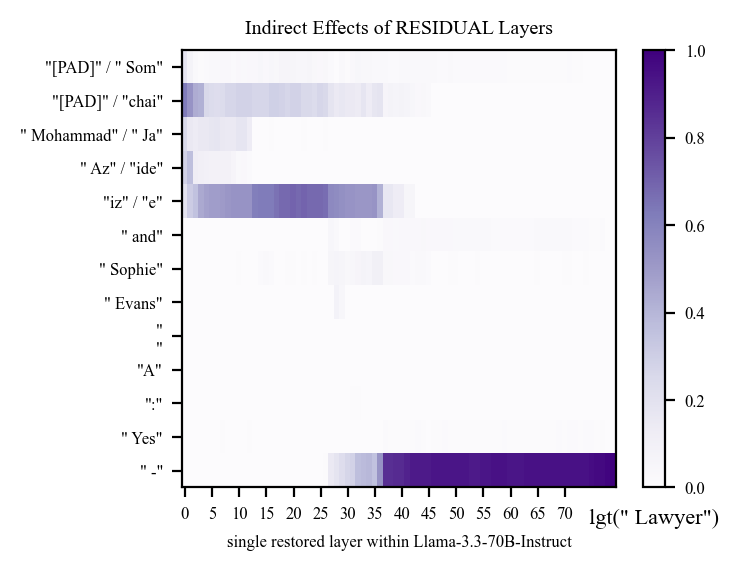

trace_start_idx=148
===> trace_start_idx=148
2025-06-26 19:36:46 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 19:36:46 src.trace DEBUG    base_score=23.0 | base_indv_scores={71314: 23.0}
2025-06-26 19:36:46 src.trace DEBUG    low_score=13.9375 | low_indv_scores={71314: 13.9375}
2025-06-26 19:36:46 src.trace DEBUG    base_score=23.0 | low_score=13.9375
2025-06-26 19:36:46 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1040/1040 [03:56<00:00,  4.40it/s]

2025-06-26 19:40:43 src.trace INFO     base_score=23.0 | low_score=13.9375
2025-06-26 19:40:43 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Check', ' if', ' Two', ' People', ' Share', ' the', ' Same', ' [', 'attribute', ']\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' the', ' same', ' [', 'attribute', '].\n', '#', ' Response', ' Format', ':\n', 'If', ' you', ' find', ' a', ' match', ':', ' Yes', ' -', ' [', 'profession', ']', ' -', ' they', ' are', ' both', ' [', 'profession', ']\n', 'If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'person', '_', '1', ']', ' is', ' a', ' [', 'profession', '_', '1', ']', ' while', ' [', 'person', '_', '2', ']', ' is', ' a', ' [', 'profession', '_', '2', ']', '"\n\n', 'Q', ':', ' Person', ' C', ' and', ' Person', ' D', '\n', 'A', ':', ' Yes', ' -', ' Doctor', ' -', ' they', ' are', '

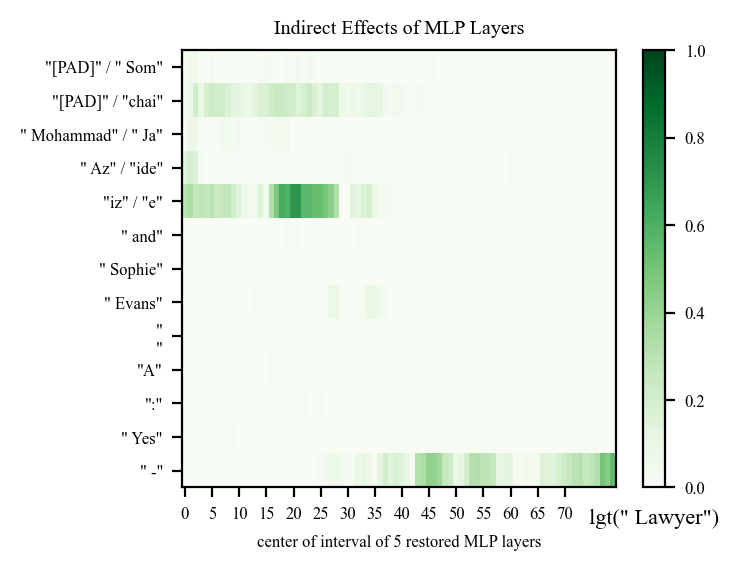

trace_start_idx=148
===> trace_start_idx=148
2025-06-26 19:40:43 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 19:40:43 src.trace DEBUG    base_score=23.0 | base_indv_scores={71314: 23.0}
2025-06-26 19:40:43 src.trace DEBUG    low_score=13.9375 | low_indv_scores={71314: 13.9375}
2025-06-26 19:40:43 src.trace DEBUG    base_score=23.0 | low_score=13.9375
2025-06-26 19:40:43 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1040/1040 [03:54<00:00,  4.43it/s]

2025-06-26 19:44:38 src.trace INFO     base_score=23.0 | low_score=13.9375
2025-06-26 19:44:38 __main__ INFO     trace_results=CausalTracingResult(patch_input_toks=['<|begin_of_text|>', '#', ' Task', ':', ' Check', ' if', ' Two', ' People', ' Share', ' the', ' Same', ' [', 'attribute', ']\n', 'You', ' will', ' be', ' given', ' two', ' people', "'s", ' names', '.', ' Your', ' job', ' is', ' to', ' determine', ' if', ' they', ' share', ' the', ' same', ' [', 'attribute', '].\n', '#', ' Response', ' Format', ':\n', 'If', ' you', ' find', ' a', ' match', ':', ' Yes', ' -', ' [', 'profession', ']', ' -', ' they', ' are', ' both', ' [', 'profession', ']\n', 'If', ' no', ' match', ':', ' "', 'No', ' -', ' [', 'person', '_', '1', ']', ' is', ' a', ' [', 'profession', '_', '1', ']', ' while', ' [', 'person', '_', '2', ']', ' is', ' a', ' [', 'profession', '_', '2', ']', '"\n\n', 'Q', ':', ' Person', ' C', ' and', ' Person', ' D', '\n', 'A', ':', ' Yes', ' -', ' Doctor', ' -', ' they', ' are', '

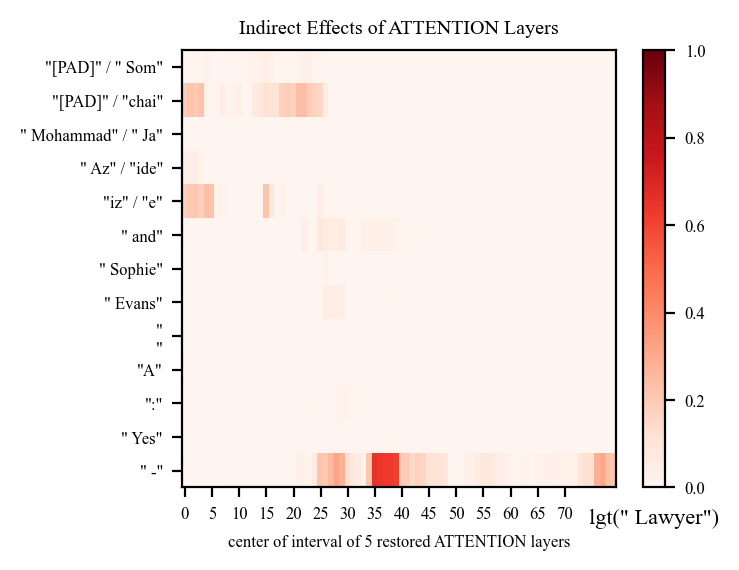

In [66]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap
from src.dataset import ActivationPatchingSamples


print(f"{samples=}")
sample = samples[0]
print(f"{sample}")

for kind in ["residual", "mlp", "attention"]:
    trace_results = trace_important_states(
        mt=connection_mt,
        prompt_template=sample.prompt_template,
        clean_subj=sample.clean_entity,
        patched_subj=sample.patched_entity,
        trace_start_marker=prefix_generator.question_marker,
        metric="logit",
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=sample.patched_answer_toks
    )

    logger.info(f"{trace_results=}")

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )

In [71]:
from tqdm.auto import tqdm
from src.functional import detensorize
import numpy as np

for idx, sample in tqdm(enumerate(samples)):
    logger.debug("-" * 50)
    logger.info(f"{idx+1}/{len(samples)} => {sample}")
    logger.debug("-" * 50)

    for kind in ["residual", "mlp", "attention"]:
        trace_results = trace_important_states(
            mt=connection_mt,
            prompt_template=sample.prompt_template,
            clean_subj=sample.clean_entity,
            patched_subj=sample.patched_entity,
            trace_start_marker=prefix_generator.question_marker,
            metric="logit",
            kind=kind,
            window_size=1 if kind == "residual" else 5,
            ans_tokens=sample.patched_answer_toks,
        )

        trace_results_dten = detensorize(trace_results)
        kind_save_dir = os.path.join(activation_patching_path, kind)
        os.makedirs(kind_save_dir, exist_ok=True)

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        np.savez_compressed(
            os.path.join(kind_save_dir, file_name),
            **trace_results_dten.__dict__,
            allow_pickle=True,
        )

    logger.debug("-" * 50)

0it [00:00, ?it/s]

2025-06-26 20:15:57 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:15:57 __main__ INFO     1/49 => Sophie Evans | Somchai Jaidee => " Academic" | <-- | Mohammad Aziz => " Lawyer"
2025-06-26 20:15:57 __main__ DEBUG    --------------------------------------------------


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:15:58 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:15:58 src.trace DEBUG    base_score=23.0 | base_indv_scores={71314: 23.0}
2025-06-26 20:15:58 src.trace DEBUG    low_score=13.9375 | low_indv_scores={71314: 13.9375}
2025-06-26 20:15:58 src.trace DEBUG    base_score=23.0 | low_score=13.9375
2025-06-26 20:15:58 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 1040/1040 [03:43<00:00,  4.65it/s]

2025-06-26 20:19:42 src.trace INFO     base_score=23.0 | low_score=13.9375


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:19:42 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:19:43 src.trace DEBUG    base_score=23.0 | base_indv_scores={71314: 23.0}
2025-06-26 20:19:43 src.trace DEBUG    low_score=13.9375 | low_indv_scores={71314: 13.9375}
2025-06-26 20:19:43 src.trace DEBUG    base_score=23.0 | low_score=13.9375
2025-06-26 20:19:43 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1040/1040 [03:44<00:00,  4.63it/s]

2025-06-26 20:23:28 src.trace INFO     base_score=23.0 | low_score=13.9375


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:23:28 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:23:29 src.trace DEBUG    base_score=23.0 | base_indv_scores={71314: 23.0}
2025-06-26 20:23:29 src.trace DEBUG    low_score=13.9375 | low_indv_scores={71314: 13.9375}
2025-06-26 20:23:29 src.trace DEBUG    base_score=23.0 | low_score=13.9375
2025-06-26 20:23:29 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1040/1040 [03:45<00:00,  4.61it/s]

2025-06-26 20:27:14 src.trace INFO     base_score=23.0 | low_score=13.9375


2025-06-26 20:27:15 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:27:15 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:27:15 __main__ INFO     2/49 => Mohammad Aziz | Chinedu Okafor => " Professor" | <-- | Sophie Evans => " Lawyer"
2025-06-26 20:27:15 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:27:15 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:27:15 src.trace DEBUG    base_score=23.125 | base_indv_scores={71314: 23.125}
2025-06-26 20:27:16 src.trace DEBUG    low_score=13.5625 | low_indv_scores={71314: 13.5625}
2025-06-26 20:27:16 src.trace DEBUG    base_score=23.125 | low_score=13.5625
2025-06-26 20:27:16 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 1200/1200 [04:18<00:00,  4.64it/s]

2025-06-26 20:31:34 src.trace INFO     base_score=23.125 | low_score=13.5625


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:31:35 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:31:35 src.trace DEBUG    base_score=23.125 | base_indv_scores={71314: 23.125}
2025-06-26 20:31:35 src.trace DEBUG    low_score=13.5625 | low_indv_scores={71314: 13.5625}
2025-06-26 20:31:35 src.trace DEBUG    base_score=23.125 | low_score=13.5625
2025-06-26 20:31:35 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1200/1200 [04:20<00:00,  4.60it/s]

2025-06-26 20:35:56 src.trace INFO     base_score=23.125 | low_score=13.5625


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 20:35:57 src.trace DEBUG    tracing answer for ['71314( Lawyer)']
2025-06-26 20:35:57 src.trace DEBUG    base_score=23.125 | base_indv_scores={71314: 23.125}
2025-06-26 20:35:58 src.trace DEBUG    low_score=13.5625 | low_indv_scores={71314: 13.5625}
2025-06-26 20:35:58 src.trace DEBUG    base_score=23.125 | low_score=13.5625
2025-06-26 20:35:58 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1200/1200 [04:36<00:00,  4.34it/s]

2025-06-26 20:40:34 src.trace INFO     base_score=23.125 | low_score=13.5625


2025-06-26 20:40:35 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:40:35 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:40:35 __main__ INFO     3/49 => Grace Wanjiru | Maria Santos => " Doctor" | <-- | Fatima Sheikh => " Urban"
2025-06-26 20:40:35 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=149
2025-06-26 20:40:35 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:40:35 src.trace DEBUG    base_score=22.625 | base_indv_scores={29422: 22.625}
2025-06-26 20:40:35 src.trace DEBUG    low_score=13.9375 | low_indv_scores={29422: 13.9375}
2025-06-26 20:40:35 src.trace DEBUG    base_score=22.625 | low_score=13.9375
2025-06-26 20:40:35 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 1040/1040 [03:57<00:00,  4.39it/s]

2025-06-26 20:44:32 src.trace INFO     base_score=22.625 | low_score=13.9375


trace_start_idx=148
===> trace_start_idx=149
2025-06-26 20:44:33 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:44:34 src.trace DEBUG    base_score=22.625 | base_indv_scores={29422: 22.625}
2025-06-26 20:44:34 src.trace DEBUG    low_score=13.9375 | low_indv_scores={29422: 13.9375}
2025-06-26 20:44:34 src.trace DEBUG    base_score=22.625 | low_score=13.9375
2025-06-26 20:44:34 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1040/1040 [03:58<00:00,  4.37it/s]

2025-06-26 20:48:32 src.trace INFO     base_score=22.625 | low_score=13.9375


trace_start_idx=148
===> trace_start_idx=149
2025-06-26 20:48:33 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:48:33 src.trace DEBUG    base_score=22.625 | base_indv_scores={29422: 22.625}
2025-06-26 20:48:33 src.trace DEBUG    low_score=13.9375 | low_indv_scores={29422: 13.9375}
2025-06-26 20:48:33 src.trace DEBUG    base_score=22.625 | low_score=13.9375
2025-06-26 20:48:33 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1040/1040 [03:58<00:00,  4.36it/s]

2025-06-26 20:52:32 src.trace INFO     base_score=22.625 | low_score=13.9375


2025-06-26 20:52:33 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:52:33 __main__ DEBUG    --------------------------------------------------
2025-06-26 20:52:33 __main__ INFO     4/49 => Fatima Sheikh | Mohammad Aziz => " Lawyer" | <-- | Grace Wanjiru => " Urban"
2025-06-26 20:52:33 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=150
2025-06-26 20:52:33 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:52:33 src.trace DEBUG    base_score=21.75 | base_indv_scores={29422: 21.75}
2025-06-26 20:52:33 src.trace DEBUG    low_score=12.0 | low_indv_scores={29422: 12.0}
2025-06-26 20:52:33 src.trace DEBUG    base_score=21.75 | low_score=12.0
2025-06-26 20:52:33 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 960/960 [03:38<00:00,  4.39it/s]

2025-06-26 20:56:12 src.trace INFO     base_score=21.75 | low_score=12.0


trace_start_idx=148
===> trace_start_idx=150
2025-06-26 20:56:13 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:56:13 src.trace DEBUG    base_score=21.75 | base_indv_scores={29422: 21.75}
2025-06-26 20:56:13 src.trace DEBUG    low_score=12.0 | low_indv_scores={29422: 12.0}
2025-06-26 20:56:13 src.trace DEBUG    base_score=21.75 | low_score=12.0
2025-06-26 20:56:13 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 960/960 [03:39<00:00,  4.37it/s]

2025-06-26 20:59:53 src.trace INFO     base_score=21.75 | low_score=12.0


trace_start_idx=148
===> trace_start_idx=150
2025-06-26 20:59:54 src.trace DEBUG    tracing answer for ['29422( Urban)']
2025-06-26 20:59:54 src.trace DEBUG    base_score=21.75 | base_indv_scores={29422: 21.75}
2025-06-26 20:59:54 src.trace DEBUG    low_score=12.0 | low_indv_scores={29422: 12.0}
2025-06-26 20:59:54 src.trace DEBUG    base_score=21.75 | low_score=12.0
2025-06-26 20:59:54 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 960/960 [03:40<00:00,  4.36it/s]

2025-06-26 21:03:34 src.trace INFO     base_score=21.75 | low_score=12.0


2025-06-26 21:03:35 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:03:35 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:03:35 __main__ INFO     5/49 => Anna Schmidt | Maria Santos => " Doctor" | <-- | Yuki Tanaka => " Marketing"
2025-06-26 21:03:35 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=150
2025-06-26 21:03:35 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:03:35 src.trace DEBUG    base_score=19.625 | base_indv_scores={18729: 19.625}
2025-06-26 21:03:36 src.trace DEBUG    low_score=13.4375 | low_indv_scores={18729: 13.4375}
2025-06-26 21:03:36 src.trace DEBUG    base_score=19.625 | low_score=13.4375
2025-06-26 21:03:36 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 800/800 [02:58<00:00,  4.48it/s]

2025-06-26 21:06:34 src.trace INFO     base_score=19.625 | low_score=13.4375


trace_start_idx=148
===> trace_start_idx=150
2025-06-26 21:06:35 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:06:35 src.trace DEBUG    base_score=19.625 | base_indv_scores={18729: 19.625}
2025-06-26 21:06:36 src.trace DEBUG    low_score=13.4375 | low_indv_scores={18729: 13.4375}
2025-06-26 21:06:36 src.trace DEBUG    base_score=19.625 | low_score=13.4375
2025-06-26 21:06:36 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 800/800 [02:57<00:00,  4.52it/s]

2025-06-26 21:09:33 src.trace INFO     base_score=19.625 | low_score=13.4375


trace_start_idx=148
===> trace_start_idx=150
2025-06-26 21:09:33 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:09:34 src.trace DEBUG    base_score=19.625 | base_indv_scores={18729: 19.625}
2025-06-26 21:09:34 src.trace DEBUG    low_score=13.4375 | low_indv_scores={18729: 13.4375}
2025-06-26 21:09:34 src.trace DEBUG    base_score=19.625 | low_score=13.4375
2025-06-26 21:09:34 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 800/800 [02:54<00:00,  4.60it/s]

2025-06-26 21:12:28 src.trace INFO     base_score=19.625 | low_score=13.4375


2025-06-26 21:12:28 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:12:28 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:12:28 __main__ INFO     6/49 => Yuki Tanaka | Mohammad Aziz => " Lawyer" | <-- | Anna Schmidt => " Marketing"
2025-06-26 21:12:28 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=148
2025-06-26 21:12:29 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:12:29 src.trace DEBUG    base_score=18.0 | base_indv_scores={18729: 18.0}
2025-06-26 21:12:29 src.trace DEBUG    low_score=10.3125 | low_indv_scores={18729: 10.3125}
2025-06-26 21:12:29 src.trace DEBUG    base_score=18.0 | low_score=10.3125
2025-06-26 21:12:29 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 1040/1040 [03:52<00:00,  4.47it/s]

2025-06-26 21:16:22 src.trace INFO     base_score=18.0 | low_score=10.3125


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 21:16:23 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:16:23 src.trace DEBUG    base_score=18.0 | base_indv_scores={18729: 18.0}
2025-06-26 21:16:23 src.trace DEBUG    low_score=10.3125 | low_indv_scores={18729: 10.3125}
2025-06-26 21:16:23 src.trace DEBUG    base_score=18.0 | low_score=10.3125
2025-06-26 21:16:23 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 1040/1040 [03:52<00:00,  4.46it/s]

2025-06-26 21:20:16 src.trace INFO     base_score=18.0 | low_score=10.3125


trace_start_idx=148
===> trace_start_idx=148
2025-06-26 21:20:17 src.trace DEBUG    tracing answer for ['18729( Marketing)']
2025-06-26 21:20:17 src.trace DEBUG    base_score=18.0 | base_indv_scores={18729: 18.0}
2025-06-26 21:20:17 src.trace DEBUG    low_score=10.3125 | low_indv_scores={18729: 10.3125}
2025-06-26 21:20:17 src.trace DEBUG    base_score=18.0 | low_score=10.3125
2025-06-26 21:20:17 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 1040/1040 [03:51<00:00,  4.49it/s]

2025-06-26 21:24:09 src.trace INFO     base_score=18.0 | low_score=10.3125


2025-06-26 21:24:09 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:24:09 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:24:09 __main__ INFO     7/49 => Nguyen Van Duc | Mohammad Aziz => " Lawyer" | <-- | Chinedu Okafor => " Marine"
2025-06-26 21:24:09 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=151
2025-06-26 21:24:10 src.trace DEBUG    tracing answer for ['23820( Marine)']
2025-06-26 21:24:10 src.trace DEBUG    base_score=20.0 | base_indv_scores={23820: 20.0}
2025-06-26 21:24:10 src.trace DEBUG    low_score=8.25 | low_indv_scores={23820: 8.25}
2025-06-26 21:24:10 src.trace DEBUG    base_score=20.0 | low_score=8.25
2025-06-26 21:24:10 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 960/960 [03:36<00:00,  4.43it/s]

2025-06-26 21:27:47 src.trace INFO     base_score=20.0 | low_score=8.25


trace_start_idx=148
===> trace_start_idx=151
2025-06-26 21:27:48 src.trace DEBUG    tracing answer for ['23820( Marine)']
2025-06-26 21:27:48 src.trace DEBUG    base_score=20.0 | base_indv_scores={23820: 20.0}
2025-06-26 21:27:48 src.trace DEBUG    low_score=8.25 | low_indv_scores={23820: 8.25}
2025-06-26 21:27:48 src.trace DEBUG    base_score=20.0 | low_score=8.25
2025-06-26 21:27:48 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 960/960 [03:36<00:00,  4.44it/s]

2025-06-26 21:31:25 src.trace INFO     base_score=20.0 | low_score=8.25


trace_start_idx=148
===> trace_start_idx=151
2025-06-26 21:31:25 src.trace DEBUG    tracing answer for ['23820( Marine)']
2025-06-26 21:31:26 src.trace DEBUG    base_score=20.0 | base_indv_scores={23820: 20.0}
2025-06-26 21:31:26 src.trace DEBUG    low_score=8.25 | low_indv_scores={23820: 8.25}
2025-06-26 21:31:26 src.trace DEBUG    base_score=20.0 | low_score=8.25
2025-06-26 21:31:26 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 960/960 [03:35<00:00,  4.46it/s]

2025-06-26 21:35:01 src.trace INFO     base_score=20.0 | low_score=8.25


2025-06-26 21:35:02 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:35:02 __main__ DEBUG    --------------------------------------------------
2025-06-26 21:35:02 __main__ INFO     8/49 => Chinedu Okafor | Mohammad Aziz => " Professor" | <-- | Nguyen Van Duc => " Marine"
2025-06-26 21:35:02 __main__ DEBUG    --------------------------------------------------
trace_start_idx=148
===> trace_start_idx=148
2025-06-26 21:35:02 src.trace DEBUG    tracing answer for ['23820( Marine)']
2025-06-26 21:35:02 src.trace DEBUG    base_score=21.25 | base_indv_scores={23820: 21.25}
2025-06-26 21:35:02 src.trace DEBUG    low_score=12.0625 | low_indv_scores={23820: 12.0625}
2025-06-26 21:35:02 src.trace DEBUG    base_score=21.25 | low_score=12.0625
2025-06-26 21:35:02 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


 78%|███████▊  | 938/1200 [03:31<00:59,  4.43it/s]


KeyboardInterrupt: 

## Parse the results

In [ ]:
activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET,
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

In [60]:
from src.trace import CausalTracingResult
import numpy as np

model_name = model_key.split("/")[-1]

load_dir = os.path.join(
    "results", "activation_patching", "test_72", target_attribute, "residual"
)

indirect_effects_collection = []
for file_name in os.listdir(load_dir):
    npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
    indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [62]:
from src.tokens import prepare_input, find_token_range

def find_common_entity_range(mt, toks, common_entity):
    text = "".join(toks)
    inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )
    rng = find_token_range(
        string=text,
        substring=common_entity,
        tokenizer=mt,
        offset_mapping=inputs["offset_mapping"][0],
        occurence=-1,
    )
    return rng

def get_token_ranges(
    mt: ModelandTokenizer,
    trace_res: CausalTracingResult,
    common_entity: str,
):
    common_entity_range_patch = find_common_entity_range(
        mt, trace_res.patch_input_toks, common_entity
    )

    assert (
        trace_res.patch_input_toks[slice(*common_entity_range_patch)]
        == trace_res.corrupt_input_toks[slice(*common_entity_range_patch)]
    )

    between_entities = (trace_res.subj_range[1], common_entity_range_patch[0])

    query_indices = (common_entity_range_patch[1], len(trace_res.patch_input_toks) - 2)

    subj_len = trace_res.subj_range[1] - trace_res.subj_range[0]
    common_len = common_entity_range_patch[1] - common_entity_range_patch[0]

    return dict(
        previous=(trace_res.trace_start_idx, trace_res.subj_range[0]),
        subj_upto_2nd_last=(trace_res.subj_range[0], trace_res.subj_range[1] - 2)
        if subj_len > 2
        else None,
        subj_2nd_last=trace_res.subj_range[1] - 2 if subj_len >= 2 else None,
        subj_last=trace_res.subj_range[1] - 1,
        between_entities=between_entities,
        common_upto_2nd_last=(
            common_entity_range_patch[0],
            common_entity_range_patch[1] - 2,
        )
        if common_len > 2
        else None,
        common_2nd_last=common_entity_range_patch[1] - 2 if common_len >= 2 else None,
        common_last=common_entity_range_patch[1] - 1,
        query_indices=query_indices,
        second_last=-2,
        last=-1,
    )

def get_categorized_indirect_effects(
    trace_res: CausalTracingResult, token_ranges: dict[str, int | tuple[int, int]]
):
    indirect_effects = {}
    for category in token_ranges:
        if token_ranges[category] is None:
            indirect_effects[category] = None
            continue
        if isinstance(token_ranges[category], int) == False:
            rng = token_ranges[category]
            rng = (
                rng[0] - trace_res.trace_start_idx,
                rng[1] - trace_res.trace_start_idx,
            )
            indirect_effects[category] = trace_res.indirect_effects[
                rng[0] : rng[1]
            ].mean(dim=0)
        else:
            idx = token_ranges[category]
            idx = idx - trace_res.trace_start_idx if idx > 0 else idx
            indirect_effects[category] = trace_res.indirect_effects[idx]

    return indirect_effects

sample_idx = 0
trace_res = indirect_effects_collection[sample_idx]
start_idx = trace_res.trace_start_idx
common_entity = (
    "".join(trace_res.patch_input_toks[start_idx:-7]).split("and")[-1].strip()
)

token_ranges = get_token_ranges(mt, trace_res, common_entity=common_entity)
categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [67]:
categorized_effects

{'previous': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        dtype=torch.float64),
 'subj_upto_2nd_last': None,
 'subj_2nd_last': tensor([0.5472, 0.8868, 0.8113, 0.7358, 0.8868, 0.7547, 0.8868, 0.7736, 0.6981,
         0.4151, 0.4151, 0.4151, 0.4340, 0.3962, 0.1887, 0.0000],
        dtype=torch.float64),
 'subj_last': tensor([-0.0377,  0.0189, -0.0566,  0.1509,  0.2264,  0.1887,  0.2453,  0.2264,
          0.2453,  0.1509,  0.2453,  0.1887,  0.2453,  0.0377,  0.0000,  0.0000],
        dtype=torch.float64),
 'between_entities': tensor([ 0.0943, -0.0566, -0.0189, -0.1132,  0.0755,  0.0377,  0.0189,  0.0189,
         -0.0943, -0.1887,  0.0189,  0.0377,  0.0377, -0.0377, -0.0189,  0.0000],
        dtype=torch.float64),
 'common_upto_2nd_last': None,
 'common_2nd_last': tensor([ 0.1132, -0.1132, -0.2075, -0.1509, -0.0943, -0.0755, -0.2264, -0.0943,
         -0.0566, -0.0189,  0.0377,  0.1321,  0.0000,  0.0189,  0.0189,  0.0000],
        dtype

In [68]:
from typing import Literal
from src.utils.typing import PredictedToken

def average_indirect_effects(
    categorized_effects: list[dict],
    kind: Literal["residual", "mlp", "attention"] = "residual",
    window: int = 1,
    metric: Literal["logit", "prob"] = "logit",
):
    aie = {
        k: torch.zeros_like(categorized_effects[0]["subj_last"])
        for k, v in categorized_effects[0].items()
    }
    for category in aie:
        category_count = 0
        for effects in categorized_effects:
            if effects[category] is not None:
                aie[category] += effects[category]
                category_count += 1
        if category_count > 0:
            aie[category] /= category_count

    return CausalTracingResult(
        patch_input_toks=list(aie.keys()),
        corrupt_input_toks=list(aie.keys()),
        indirect_effects=torch.stack(list(aie.values())),
        trace_start_idx=0,
        answer=[PredictedToken(token="Ans", prob=1.0, logit=10.0)],
        low_score=0.0,
        base_score=1.0,
        subj_range=(1, 4),
        normalized=True,
        kind=kind,
        window=window,
        metric=metric,
    )

aie = average_indirect_effects(categorized_effects=[categorized_effects])

In [69]:
aie

CausalTracingResult(patch_input_toks=['previous', 'subj_upto_2nd_last', 'subj_2nd_last', 'subj_last', 'between_entities', 'common_upto_2nd_last', 'common_2nd_last', 'common_last', 'query_indices', 'second_last', 'last'], corrupt_input_toks=['previous', 'subj_upto_2nd_last', 'subj_2nd_last', 'subj_last', 'between_entities', 'common_upto_2nd_last', 'common_2nd_last', 'common_last', 'query_indices', 'second_last', 'last'], trace_start_idx=0, answer=[PredictedToken(token='Ans', prob=1.0, logit=10.0, token_id=None, metadata=None)], low_score=0.0, base_score=1.0, indirect_effects=tensor([[    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5472,  0.8868,  0.8113,  0.7358,  0.8868,  0.7547,  0.8868,  0.7736,
          0.

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d89e5f250>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


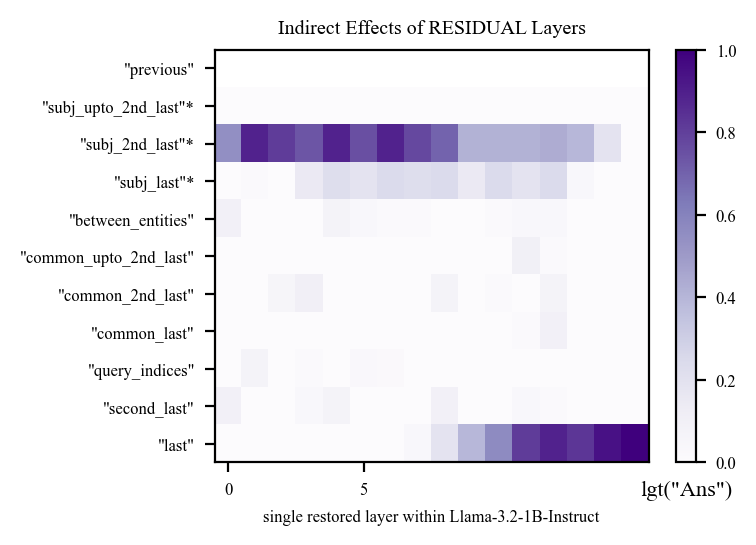

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d88b75750>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


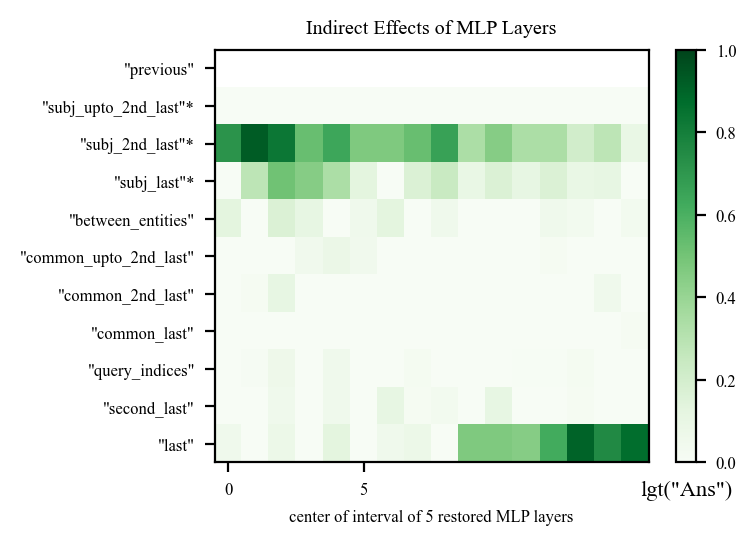

2025-06-26 10:56:14 __main__ INFO     (1/1) Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-26 10:56:14 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f3d88893d30>
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-06-26 10:56:14 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


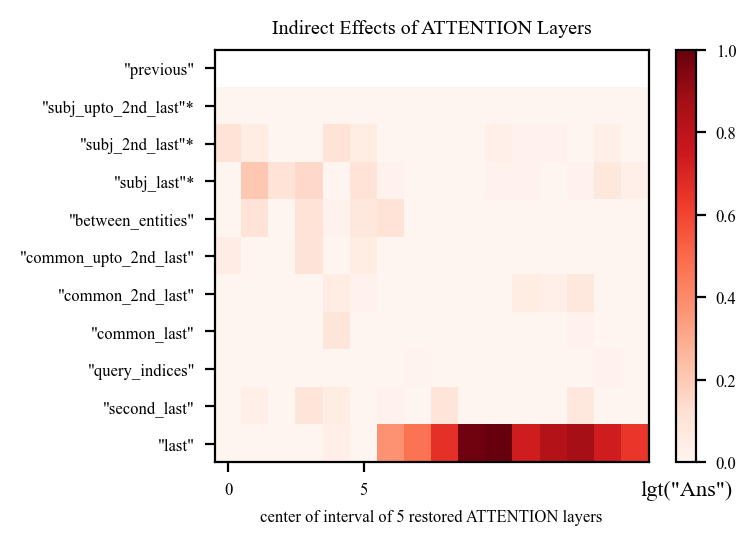

In [70]:
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(
        "results", "activation_patching", "test_72", target_attribute, kind
    )

    categorized_effects = []
    window, metric = None, None
    for idx, sample in enumerate(samples):
        logger.info(f"({idx + 1}/{len(samples)}) {sample}")

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        window = trace_res.window
        metric = trace_res.metric
        token_ranges = get_token_ranges(mt, trace_res, common_entity=sample.common_entity)
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )
    
    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind,
        window=window,
        metric=metric
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_name,
        scale_range=(0, 1) if aie.normalized == True else None,
    )

In [ ]:
# Modified version of your code with attribute hit counting
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair

limit = 1000
results = {}

for profile in profiles:
    entity_name = profile["name"]
    self_pair = (entity_name, entity_name)
    logger.info("-"* 10 + f" {entity_name} " + "-" * 10)
    predictions = []
    counter = 0
    entity_results = []
    set_seed(9001)
    connection, next_tok_probs = get_connection_on_entity_pair(
        mt=mt,
        entities=self_pair,
        prefix_generator=prefix_generator,
        n_valid=10,
        n_none=1,
        enable_reasoning=False,
        return_next_token_probs=True,
        answer_prefix=" Yes -"
    )
    next_tok_print = [str(pred) for pred in next_tok_probs[0]]
    logger.debug(f"{self_pair} | {next_tok_print}")
    entity_results.append({
        "entity": entity_name,
        "connection": connection,
        "next_tok_probs": next_tok_probs[0],
    })
    predictions.append([pred.token for pred in next_tok_probs[0]])

    counter += 1
    if counter >= limit:
        break
    
    # Count attribute hits for this entity by category
    predictions_tokens = [pred.token for pred in next_tok_probs[0]]
    hit_analysis = count_attribute_hits_by_category(predictions_tokens, profile, top_k=15)
    
    # Log overall hit rate
    overall = hit_analysis['overall']
    logger.info(f"{entity_name} => Overall hit rate: {overall['hit_rate']:.2f} ({overall['hit_count']}/{overall['total_predictions']})")
    
    # Log category breakdown
    category_summary = []
    for category, cat_results in hit_analysis['by_category'].items():
        if cat_results['hit_count'] > 0:
            category_summary.append(f"{category}: {cat_results['hit_count']}")
    
    if category_summary:
        logger.info(f"{entity_name} => By category: {', '.join(category_summary)}")
        
        # Show detailed hits for debugging
        hit_details = []
        for hit in overall['all_hits'][:5]:  # Show top 5 hits
            hit_details.append(f"#{hit['position']}: '{hit['predicted_token']}' -> {hit['category']}:{hit['matched_attribute']}")
        logger.debug(f"Top hits: {'; '.join(hit_details)}")

    results[entity_name] = {
        "entity": entity_name,
        "hit_analysis": hit_analysis,
        "results": entity_results,
    }


In [ ]:
# Analyze the overall attribute hit statistics by category
import numpy as np
from collections import defaultdict

hit_rates = []
total_hits = 0
total_predictions = 0

# Track hits by category across all entities
category_stats = defaultdict(lambda: {'hits': 0, 'total_entities': 0, 'entities_with_hits': 0})

print("=== ATTRIBUTE HIT ANALYSIS SUMMARY (BY CATEGORY) ===")
print()

# Individual entity analysis
for entity_name, result in results.items():
    hit_analysis = result["hit_analysis"]
    overall = hit_analysis["overall"]
    
    hit_rates.append(overall["hit_rate"])
    total_hits += overall["hit_count"]
    total_predictions += overall["total_predictions"]
    
    # Category breakdown for this entity
    categories_with_hits = []
    for category, cat_data in hit_analysis["by_category"].items():
        category_stats[category]['total_entities'] += 1
        category_stats[category]['hits'] += cat_data['hit_count']
        
        if cat_data['hit_count'] > 0:
            category_stats[category]['entities_with_hits'] += 1
            categories_with_hits.append(f"{category}:{cat_data['hit_count']}")
    
    categories_str = ', '.join(categories_with_hits) if categories_with_hits else 'none'
    print(f"{entity_name:25} | Overall: {overall['hit_rate']:.3f} ({overall['hit_count']:2d}/{overall['total_predictions']:2d}) | Categories: {categories_str}")

print()
print(f"=== OVERALL STATISTICS ===")
print(f"  Average hit rate: {np.mean(hit_rates):.3f} ± {np.std(hit_rates):.3f}")
print(f"  Total hits: {total_hits}/{total_predictions} = {total_hits/total_predictions:.3f}")
print(f"  Entities with >50% hit rate: {sum(1 for hr in hit_rates if hr > 0.5)}/{len(hit_rates)}")
print(f"  Entities with >25% hit rate: {sum(1 for hr in hit_rates if hr > 0.25)}/{len(hit_rates)}")

print()
print(f"=== STATISTICS BY ATTRIBUTE CATEGORY ===")
for category, stats in sorted(category_stats.items()):
    avg_hits_per_entity = stats['hits'] / stats['total_entities'] if stats['total_entities'] > 0 else 0
    success_rate = stats['entities_with_hits'] / stats['total_entities'] if stats['total_entities'] > 0 else 0
    
    print(f"{category:20} | Total hits: {stats['hits']:3d} | Avg hits/entity: {avg_hits_per_entity:.2f} | Success rate: {success_rate:.2f} ({stats['entities_with_hits']}/{stats['total_entities']})")

# Show some example hits by category
print()
print("=== EXAMPLE HITS BY CATEGORY ===")
examples_by_category = defaultdict(list)

for entity_name, result in results.items():
    hit_analysis = result["hit_analysis"]
    for hit in hit_analysis["overall"]["all_hits"]:
        if len(examples_by_category[hit['category']]) < 3:  # Limit examples per category
            examples_by_category[hit['category']].append((entity_name, hit))

for category, examples in sorted(examples_by_category.items()):
    print(f"\n{category.upper()}:")
    for entity_name, hit in examples:
        print(f"  {entity_name}: #{hit['position']} '{hit['predicted_token']}' -> {hit['matched_attribute']}")


In [ ]:
# Test the attribute extraction for a specific entity
def test_attribute_extraction(entity_name):
    """Test the attribute extraction for debugging purposes."""
    profile = names_to_profiles[entity_name]
    attr_values = get_attr_vals(profile)
    
    print(f"=== TESTING ATTRIBUTE EXTRACTION FOR {entity_name} ===")
    print(f"Profile keys: {list(profile.keys())}")
    print(f"Extracted {len(attr_values)} attribute values:")
    
    # Group by type for better readability
    print("\nAttribute values:")
    for i, val in enumerate(sorted(set(attr_values))[:20]):  # Show first 20
        print(f"  {i+1:2d}. '{val}'")
    
    if len(attr_values) > 20:
        print(f"  ... and {len(attr_values) - 20} more")
    
    return attr_values

# Test for a couple entities from your debug output
print("Testing attribute extraction for Mohammad Aziz:")
test_attr_mohammad = test_attribute_extraction("Mohammad Aziz")

print("\n" + "="*60)
print("Testing attribute extraction for Fatima Sheikh:")
test_attr_fatima = test_attribute_extraction("Fatima Sheikh")


In [ ]:
# Test the attribute extraction for a specific entity
def test_attribute_extraction_by_category(entity_name):
    """Test the attribute extraction by category for debugging purposes."""
    profile = names_to_profiles[entity_name]
    attr_by_category = get_attr_vals_by_category(profile)
    
    print(f"=== TESTING ATTRIBUTE EXTRACTION FOR {entity_name} ===")
    print(f"Profile keys: {list(profile.keys())}")
    print(f"Extracted attributes in {len(attr_by_category)} categories:")
    
    for category, values in attr_by_category.items():
        print(f"\n{category.upper()} ({len(values)} variations):")
        # Show first 10 variations per category
        for i, val in enumerate(sorted(set(values))[:10]):
            print(f"  {i+1:2d}. '{val}'")
        if len(values) > 10:
            print(f"  ... and {len(values) - 10} more")
    
    return attr_by_category

def test_predictions_against_attributes(entity_name, sample_predictions):
    """Test how the predictions match against attribute categories."""
    profile = names_to_profiles[entity_name]
    hit_analysis = count_attribute_hits_by_category(sample_predictions, profile, top_k=15)
    
    print(f"\n=== TESTING PREDICTION MATCHING FOR {entity_name} ===")
    print(f"Sample predictions: {sample_predictions[:5]}...")
    
    overall = hit_analysis['overall']
    print(f"Overall hit rate: {overall['hit_rate']:.2f} ({overall['hit_count']}/{overall['total_predictions']})")
    
    print("\nBy category:")
    for category, cat_data in hit_analysis['by_category'].items():
        if cat_data['hit_count'] > 0:
            print(f"  {category}: {cat_data['hit_count']} hits")
            for hit in cat_data['hits']:
                print(f"    #{hit['position']}: '{hit['predicted_token']}' -> {hit['matched_attribute']}")
    
    return hit_analysis

# Test for a couple entities from your debug output  
print("Testing attribute extraction by category...")
if 'Mohammad Aziz' in names_to_profiles:
    test_attribute_extraction_by_category('Mohammad Aziz')

# Test with sample predictions from your debug output
sample_predictions_aziz = ['" Chess"', '" Same"', '" Painting"', '" Pakistani"', '" Doctor"', '" same"', '" Lawyer"', '" Law"', '" Dog"', '" Cat"', '" Car"', '" National"', '" Coffee"', '" Name"', '" S"']

print("\n" + "="*70)
if 'Mohammad Aziz' in names_to_profiles:
    test_predictions_against_attributes('Mohammad Aziz', sample_predictions_aziz)
